# 1. Data cleaning/pre-processing/filtering

### library Set-up & Data Loading

In [57]:
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.2 MB 4.6 MB/s 
     |████████████████████████████████| 588.3 MB 21 kB/s 
     |████████████████████████████████| 1.7 MB 51.1 MB/s 
     |████████████████████████████████| 6.0 MB 53.0 MB/s 
     |████████████████████████████████| 439 kB 46.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats, interpolate
from scipy.interpolate import interp1d
from scipy.stats import mode

from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import tensorflow_decision_forests as tfdf

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')

### Helper Functions

Define function to help remove NAN


In [4]:
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

###Label Set-up

In [65]:
#info that will be reused throughout the program
LABELS = ['front_left', 
          'front_right', 
          'back_left', 
          'back_right']
TIME_PERIODS = 180
STEP_DISTANCE = 60

### Load IMU Data

In [6]:
%cd /content/drive/MyDrive/ml_sensing_fproject/data

fl_fns = []
for i in range(1,7):
  fl_fns.append("fl_pocket-0" + str(i) + ".csv")

fr_fns = ["fr_pocket-01.csv"]
bl_fns = ["bl_pocket-01.csv"]
br_fns = ["br_pocket-01.csv"]

# Read data files
df_fl = pd.concat(map(pd.read_csv, fl_fns), ignore_index=True)
df_fl["orientation"] = 'front_left'

df_fr = pd.concat(map(pd.read_csv, fr_fns), ignore_index=True)
df_fr["orientation"] = 'front_right'

df_bl = pd.concat(map(pd.read_csv, bl_fns), ignore_index=True)
df_bl["orientation"] = 'back_left'

df_br = pd.concat(map(pd.read_csv, br_fns), ignore_index=True)
df_br["orientation"] = 'back_right'

/content/drive/MyDrive/ml_sensing_fproject/data


###Data Cleaning & Filtering

In [7]:
df_list = [df_fl, df_fr, df_bl, df_br]
df = pd.concat(df_list, axis = 0)
df['num'] = np.random.randint(1, 30, df.shape[0])

# ... and then these columns must be transformed to float explicitly
df[' AccelerationX'] = df[' AccelerationX'].apply(convert_to_float)
df[ 'AccelerationY'] = df[' AccelerationY'].apply(convert_to_float)
df[' AccelerationZ'] = df[' AccelerationZ'].apply(convert_to_float)

df[' GyroX'] = df[' GyroX'].apply(convert_to_float)
df[' GyroY'] = df[' GyroY'].apply(convert_to_float)
df[' GyroZ'] = df[' GyroZ'].apply(convert_to_float)

df[' MagneticFieldX'] = df[' MagneticFieldX'].apply(convert_to_float)
df[' MagneticFieldY'] = df[' MagneticFieldY'].apply(convert_to_float)
df[' MagneticFieldZ'] = df[' MagneticFieldZ'].apply(convert_to_float)

# ... clean up all NAN
df.dropna(axis=0, how='any', inplace=True)

<ipython-input-4-106b90fe2a87>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


Set up df with labels and get prepared for model training

In [8]:
LABEL = 'activityEncode'
label_encode = preprocessing.LabelEncoder()
df[LABEL] = label_encode.fit_transform(df['orientation'].values.ravel())

### Inspect the Accelerometer Data


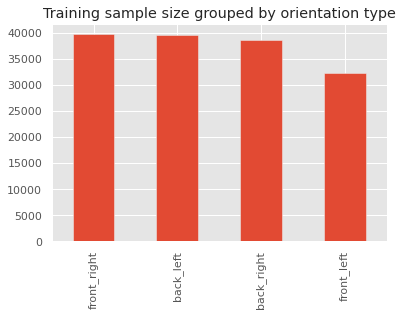

In [30]:
df['orientation'].value_counts().plot(kind='bar', title='Training sample size grouped by orientation type')
plt.show()

Looking at the accelerometer data for each of the three axis for all four activities, since I recorded my data at a sampling rate of 20 Hz, I know I will have 20 values per second. 

I wanted to check out the first 180 records, each chart shows a 9 second interval for each of the four activities (calculation: 0.05 * 180 = 9 seconds).

### Split Data into Training and Test Set


I decided to split the data based on the groups I assigned to cluster data. I put 'num' ID 1 to 25 for training the model and greater than 25 for the test set.

In [9]:
# Differentiate between test set and training set
df_test = df[df['num'] > 25]
df_train = df[df['num'] <= 25]

### Data Pre-processing

Normalize features for training data set (values between 0 and 1)

In [11]:
# Normalize features for training data set (values between 0 and 1)
df_train[' AccelerationX'] = (df_train[' AccelerationX']-df_train[' AccelerationX'].min())/(df_train[' AccelerationX'].max()-df_train[' AccelerationX'].min())
df_train[' AccelerationY'] = (df_train[' AccelerationY']-df_train[' AccelerationY'].min())/(df_train[' AccelerationY'].max()-df_train[' AccelerationY'].min())
df_train[' AccelerationZ'] = (df_train[' AccelerationZ']-df_train[' AccelerationZ'].min())/(df_train[' AccelerationZ'].max()-df_train[' AccelerationZ'].min())

df_train[' MagneticFieldX'] = (df_train[' MagneticFieldX']-df_train[' MagneticFieldX'].min())/(df_train[' MagneticFieldX'].max()-df_train[' MagneticFieldX'].min())
df_train[' MagneticFieldY'] = (df_train[' MagneticFieldY']-df_train[' MagneticFieldY'].min())/(df_train[' MagneticFieldY'].max()-df_train[' MagneticFieldY'].min())
df_train[' MagneticFieldZ'] = (df_train[' MagneticFieldZ']-df_train[' MagneticFieldZ'].min())/(df_train[' MagneticFieldZ'].max()-df_train[' MagneticFieldZ'].min())

df_train[' GyroX'] = (df_train[' GyroX']-df_train[' GyroX'].min())/(df_train[' GyroX'].max()-df_train[' GyroX'].min())
df_train[' GyroY'] = (df_train[' GyroY']-df_train[' GyroY'].min())/(df_train[' GyroY'].max()-df_train[' GyroY'].min())
df_train[' GyroZ'] = (df_train[' GyroZ']-df_train[' GyroZ'].min())/(df_train[' GyroZ'].max()-df_train[' GyroZ'].min())

# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

### Feature selection



The data contained in the dataframe is not ready yet to be fed into a neural network. 
I need to reshape them into segments and prepare for Keras

I created the following function which takes in the dataframe and the label names (the activity) as well as the length of each record. 

I set a preliminary choice of step to be 80. The consideration behind was that my data were captured at 20 Hz sampling rate, this equals to 5 second time intervals (calculation: 0.05 * 100 = 5). 

Besides reshaping the data, the function will also separate the features (AccelerationX, AccelerationY, AccelerationZ) and the labels (associated activity).

In [12]:
def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 9
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        axs = df[' AccelerationX'].values[i: i + time_steps]
        ays = df[' AccelerationY'].values[i: i + time_steps]
        azs = df[' AccelerationZ'].values[i: i + time_steps]

        gxs = df[' GyroX'].values[i: i + time_steps]
        gys = df[' GyroY'].values[i: i + time_steps]
        gzs = df[' GyroZ'].values[i: i + time_steps]

        axs = df[' MagneticFieldX'].values[i: i + time_steps]
        ays = df[' MagneticFieldY'].values[i: i + time_steps]
        azs = df[' MagneticFieldZ'].values[i: i + time_steps]

        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([axs, ays, azs, gxs, gys, gzs, axs, ays, azs])
        labels.append(label)
    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    return reshaped_segments, labels

In [66]:
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [67]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (2157, 180, 9)
2157 training samples
y_train shape:  (2157,)


# 2. Model Training

#### Set input & output dimensions


In [68]:
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = label_encode.classes_.size

print(list(label_encode.classes_))

['back_left', 'back_right', 'front_left', 'front_right']


#### Data Preparation

In [69]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
y_train_hot = to_categorical(y_train, num_classes)

In [70]:
print('input_shape:', input_shape)
print('x_train shape:', x_train.shape)
print('New y_train shape: ', y_train_hot.shape)

input_shape: 1620
x_train shape: (2157, 1620)
New y_train shape:  (2157, 4)


#### Creating a Model

In [71]:
model = tfdf.keras.RandomForestModel()

Use /tmp/tmpyw5zmg3q as temporary training directory


#### Fit the Model in Keras

In [76]:
model.compile(metrics=["mae"])
# Hyper-parameters
BATCH_SIZE = 100
EPOCHS = 1

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS)

Reading training dataset...
Training dataset read in 0:00:18.837921. Found 2157 examples.
Training model...
Model trained in 0:00:57.932614
Compiling model...
Model compiled.


### Prep for Model Performance Evaluation & Visualization

Create test data for evaluation

In [79]:
df_test[' AccelerationX'] = (df_test[' AccelerationX']-df_test[' AccelerationX'].min())/(df_test[' AccelerationX'].max()-df_test[' AccelerationX'].min())
df_test[' AccelerationY'] = (df_test[' AccelerationY']-df_test[' AccelerationY'].min())/(df_test[' AccelerationY'].max()-df_test[' AccelerationY'].min())
df_test[' AccelerationZ'] = (df_test[' AccelerationZ']-df_test[' AccelerationZ'].min())/(df_test[' AccelerationZ'].max()-df_test[' AccelerationZ'].min())

df_test[' MagneticFieldX'] = (df_test[' MagneticFieldX']-df_test[' MagneticFieldX'].min())/(df_test[' MagneticFieldX'].max()-df_test[' MagneticFieldX'].min())
df_test[' MagneticFieldY'] = (df_test[' MagneticFieldY']-df_test[' MagneticFieldY'].min())/(df_test[' MagneticFieldY'].max()-df_test[' MagneticFieldY'].min())
df_test[' MagneticFieldZ'] = (df_test[' MagneticFieldZ']-df_test[' MagneticFieldZ'].min())/(df_test[' MagneticFieldZ'].max()-df_test[' MagneticFieldZ'].min())

df_test[' GyroX'] = (df_test[' GyroX']-df_test[' GyroX'].min())/(df_test[' GyroX'].max()-df_test[' GyroX'].min())
df_test[' GyroY'] = (df_test[' GyroY']-df_test[' GyroY'].min())/(df_test[' GyroY'].max()-df_test[' GyroY'].min())
df_test[' GyroZ'] = (df_test[' GyroZ']-df_test[' GyroZ'].min())/(df_test[' GyroZ'].max()-df_test[' GyroZ'].min())

x_test, y_test = create_segments_and_labels(df_test,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

x_test = x_test.reshape(x_test.shape[0], input_shape)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test = to_categorical(y_test, num_classes)

<ipython-input-79-b8a9709de067>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[' AccelerationX'] = (df_test[' AccelerationX']-df_test[' AccelerationX'].min())/(df_test[' AccelerationX'].max()-df_test[' AccelerationX'].min())
<ipython-input-79-b8a9709de067>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[' AccelerationY'] = (df_test[' AccelerationY']-df_test[' AccelerationY'].min())/(df_test[' AccelerationY'].max()-df_test[' AccelerationY'].min())
<ipython-input-79-b8a9709de067>:3: Setting

Create confusion matrix plotting function

In [80]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

### Result of Model

In [81]:
# Print confusion matrix for training data
y_pred_train = model.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

68/68 [==============================] - 7s 10ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       568
         1.0       1.00      1.00      1.00       554
         2.0       1.00      1.00      1.00       463
         3.0       1.00      1.00      1.00       572

    accuracy                           1.00      2157
   macro avg       1.00      1.00      1.00      2157
weighted avg       1.00      1.00      1.00      2157



In [82]:
score = model_B.evaluate(x_test, y_test)
print(score)

11/11 [==============================] - 0s 2ms/step
[]


11/11 [==============================] - 6s 10ms/step


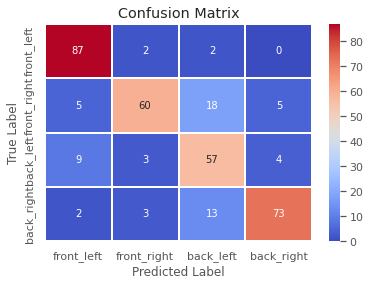

              precision    recall  f1-score   support

           0       0.84      0.96      0.90        91
           1       0.88      0.68      0.77        88
           2       0.63      0.78      0.70        73
           3       0.89      0.80      0.84        91

    accuracy                           0.81       343
   macro avg       0.81      0.81      0.80       343
weighted avg       0.82      0.81      0.81       343



In [83]:
y_pred_test = model.predict(x_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

In [85]:
model.save('../trained_model-v1')